In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

## Build Webcrawler

In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "viewit.ae" # <- put your domain to be crawled
full_url = "https://viewit.ae/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [2]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [3]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [4]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [ ]:
crawl(full_url)

## Build Embeddings Index

In [5]:
import pandas as pd

#### Data Cleaning

In [6]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [8]:
# Create text list to store text files
texts = []
domain = 'viewit.ae'

# Get all the text files in the text directory
for file in os.listdir('text/'+domain+'/'):

    # Open file and read text
    with open('text/'+domain+'/'+file, 'r', encoding='utf-8') as f:
        text = f.read()

        # Omit first 11 lines and last 4 lines, and replace -, _, and #update with spaces.
        texts.append((file[10:-4].replace('-', ' ').replace('_', ' ').replace('#update', ' '), text))


In [9]:
# Create a DataFrame from list of texts
df = pd.DataFrame(texts, columns=['fname', 'text'])
df.head()

,fname,text
0,,\n\n\nView IT - Dubai's number one property we...
1,,\n\n\nView IT - Dubai's number one property we...
2,about#contact form,\n\n\nView IT - Dubai's number one property we...
3,about,\n\n\nView IT - Dubai's number one property we...
4,listings,\n\n\nView IT Search For Properties\n\n\n \n ...


In [10]:
# Set the text column to be the raw text with newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.head()

C:\Users\ga201\AppData\Local\Temp\ipykernel_8748\2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,,. View IT - Dubai's number one property websi...
1,,. View IT - Dubai's number one property websi...
2,about#contact form,about#contact form. View IT - Dubai's number ...
3,about,about. View IT - Dubai's number one property ...
4,listings,listings. View IT Search For Properties B...


In [11]:
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,,. View IT - Dubai's number one property websi...
1,,. View IT - Dubai's number one property websi...
2,about#contact form,about#contact form. View IT - Dubai's number ...
3,about,about. View IT - Dubai's number one property ...
4,listings,listings. View IT Search For Properties B...


### Tokenizing

In [11]:
import tiktoken

In [12]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding('cl100k_base')

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']
df.head()

,title,text
0,NaN,. View IT - Dubai's number one property websi...
1,NaN,. View IT - Dubai's number one property websi...
2,about#contact form,about#contact form. View IT - Dubai's number ...
3,about,about. View IT - Dubai's number one property ...
4,listings,listings. View IT Search For Properties B...


<AxesSubplot: >

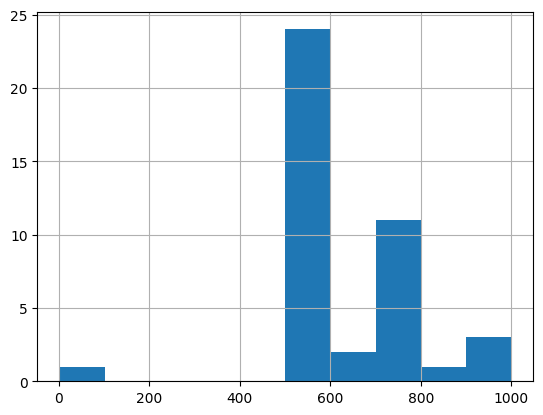

In [13]:
# Tokenize text and save the no. of tokens to new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distributon of number of tokens per row with a histogram
df.n_tokens.hist()

In [14]:
df.shape

(42, 3)

In [15]:
max_tokens = 500

# Function to split text into chunks of max number of tokens
def split_into_many(text, max_tokens=max_tokens):

    # Split text to sentences
    sentences = text.split('. ')

    # Get no. of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through sentences and tokens zipped together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If no. of tokens so far + no. of tokens in current sentence is greater than
        # the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append('. '.join(chunk) + '.')
            chunk = []
            tokens_so_far = 0

        # If no. of tokens in current sentence is greater than max tokens, go to next sentence
        if token > max_tokens:
            continue

        # Otherwise add sentence to chunk and add no. of tokens to total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


In [16]:
shortened = []

# Loop through DataFrame
for row in df.iterrows():

    # if text is None, go to next row
    if row[1]['text'] is None:
        continue

    # If no. of tokens is greater than max tokens, split text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise add text to list of shortened texts
    else:
        shortened.append(row[1]['text'])

In [17]:
df = pd.DataFrame(shortened, columns=['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.head()

,text,n_tokens
0,. View IT - Dubai's number one property websi...,331
1,Beds 1 2 3 4 5 6 ViewIT ...,486
2,. View IT - Dubai's number one property websi...,331
3,Beds 1 2 3 4 5 6 ViewIT ...,486
4,about#contact form. View IT - Dubai's number ...,488


<AxesSubplot: >

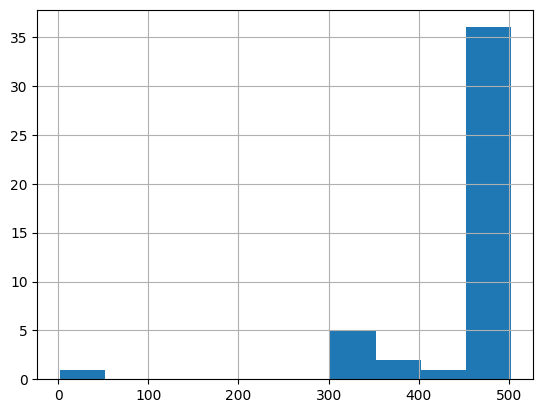

In [18]:
df.n_tokens.hist()

### Create Embeddings

In [19]:
import openai
from creds import api_key

In [21]:
#viewit api key
openai.api_key = api_key

In [22]:
df['embeddings'] = df.text.apply(
    lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding']
)

In [23]:
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,. View IT - Dubai's number one property websi...,331,"[-0.000547883624676615, 3.8956197386141866e-05..."
1,Beds 1 2 3 4 5 6 ViewIT ...,486,"[0.004306596703827381, 0.018169928342103958, -..."
2,. View IT - Dubai's number one property websi...,331,"[-0.0005997214466333389, 2.804505356834852e-06..."
3,Beds 1 2 3 4 5 6 ViewIT ...,486,"[0.004306596703827381, 0.018169928342103958, -..."
4,about#contact form. View IT - Dubai's number ...,488,"[-0.005938783288002014, -0.014180973172187805,..."


# Question-Answer System

In [24]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

In [25]:
df = pd.read_csv('processed/embeddings.csv', index_col=0)

# Convert embeddings to numpy array
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()

,text,n_tokens,embeddings
0,. View IT - Dubai's number one property websi...,331,"[-0.000547883624676615, 3.8956197386141866e-05..."
1,Beds 1 2 3 4 5 6 ViewIT ...,486,"[0.004306596703827381, 0.018169928342103958, -..."
2,. View IT - Dubai's number one property websi...,331,"[-0.0005997214466333389, 2.804505356834852e-06..."
3,Beds 1 2 3 4 5 6 ViewIT ...,486,"[0.004306596703827381, 0.018169928342103958, -..."
4,about#contact form. View IT - Dubai's number ...,488,"[-0.005938783288002014, -0.014180973172187805,..."


### Convert questions (prompts) into embeddings

In [39]:
def create_context(question, df, maxlen=1800, size="ada"):
    '''
    Create a context for a question by finding the most similar context from the DataFrame
    '''

    # Get embeddings for question
    q_embeddings = openai.Embedding.create(input=question, engine="text-embedding-ada-002")['data'][0]['embedding']

    # Get distance from embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add text to context till context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add length of text to current length
        cur_len += row['n_tokens'] + 4

        # If context too long, break
        if cur_len > maxlen:
            break

        # Else add it to the text being returned
        returns.append(row['text'])

    # Return context
    return '\n\n###\n\n'.join(returns)

In [44]:
def answer_question(
        df=df,
        model= "text-davinci-003",
        question = "Hi, please introduce yourself", # This is the default question
        max_len = 1800,
        size = 'ada',
        debug = False,
        max_tokens = 500,
        stop_sequence = None
):
    '''
    Answer a question based on the most similar context from DataFrame texts
    '''
    context = create_context(
        question,
        df,
        maxlen=max_len,
        size=size
    )

    # if debug enabled, print raw response
    if debug:
        print('Context:\n' + context)
        print('\n\n')

    try:
        # create Completion using question and context
        response = openai.Completion.create(
            prompt= f"""You are a virtual property broker for the real estate company 'ViewIt'. Be friendly and welcoming and answer the question based on the context below.
            
            Context: {context}
            
            ---
            
            Question: {question}
            Answer: """,
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model
        )
        return response['choices'][0]['text'].strip()
    except Exception as e:
        print(e)
        return ''

In [36]:
answer_question(df, question='What are you?', debug=False)

'I am a virtual property broker for the real estate company ViewIt. We provide an end-to-end real estate solution, combining the agent and client journey into one seamless experience. Agents use ViewITs proprietary tech to upload customized video listings. Clients then watch and interact with these listings and if they like what they see, they can contact the agent for further details.'

In [37]:
answer_question(df, question='Hi')

"Hi there! Welcome to ViewIT, Dubai's number one property website for properties for sale and to rent. We offer a streamlined process for agents and clients to find the perfect property. How can I help you today?"

In [45]:
answer_question() # default prompt: 'Hi, please introduce yourself'

"Hi there! I'm a virtual property broker for ViewIT, Dubai's number one property website for properties for sale and to rent. We offer an end-to-end real estate solution, combining the agent and client journey into one seamless experience. Our proprietary tech allows agents to upload customized video listings, and clients can watch and interact with these listings and contact the agent for further details. I'm here to help you find the perfect property for you!"

In [ ]:
answer_question()